In [1]:
import datetime
import json
import os
import pickle
import time

import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import (
    Activation,
    AveragePooling2D,
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    MaxPooling2D,
    Rescaling,
)
from keras.models import Sequential
from keras.preprocessing import image
from PIL import Image, ImageFont
import random
import visualkeras

# Disable tenforflow information messages about GPU
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [2]:
# set the directories pointing to the data
dir_train_data = "./augmented_images/train"
dir_test_data = "./augmented_images/test"

# train split from the training directory
train_data = tf.keras.utils.image_dataset_from_directory(
    directory=dir_train_data,
    batch_size=32,
    image_size=(224, 224),
    seed=123,
    shuffle=True,
)

# test split from the test directory
# the idea is to use the test split for choosing the right model and therefore we need more images than
# the validation set. The test set uses "training" for the subset argument, but it won't be used for training
# purposes. The argument is used by the function to decide which is the bigger split
test_data = tf.keras.utils.image_dataset_from_directory(
    directory=dir_test_data,
    batch_size=32,
    image_size=(224, 224),
    seed=123,
    shuffle=True
)

Found 384 files belonging to 2 classes.
Found 384 files belonging to 2 classes.


In [3]:
# Check the size of the images to maker sure it was saved correctly
# Also, check the maximum pixel value to make sure they weren't scaled
# before
image_batch, labels_batch = next(iter(train_data))

print("Image shape is", image_batch[0].numpy().shape)
print("Max pixel values is", np.max(image_batch[0].numpy()))

print("-----")
# Check the size of the batches
for image_batch, labels_batch in train_data:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

print("-----")

# Check the number and name of the classes, which is inferred from the
# folder structure
train_data.class_names

Image shape is (224, 224, 3)
Max pixel values is 255.0
-----
(32, 224, 224, 3)
(32,)
-----


['faulty', 'ok']

In [4]:
# Define the scaling layer
scaling_layer = Rescaling(1.0 / 255)

# Scale the datasets
train_data_scaled = train_data.map(lambda x, y: (scaling_layer(x), y))
test_data_scaled = test_data.map(lambda x, y: (scaling_layer(x), y))

# Test that the scaling has worked by printing the min and max value from one the images
image_batch, labels_batch = next(iter(train_data_scaled))

image = image_batch[0]
print(np.min(image), np.max(image))

AUTOTUNE = tf.data.AUTOTUNE

train_data_scaled = train_data_scaled.cache().prefetch(buffer_size=AUTOTUNE)
test_data_scaled = test_data_scaled.cache().prefetch(buffer_size=AUTOTUNE)

0.0 1.0


# VGG Model

In [5]:
from tensorflow.keras.layers import Input

vgg16_base_model = tf.keras.applications.VGG16(
    include_top=False,
    input_shape=(224, 224, 3),
    weights="imagenet",
)

global_average_layer = keras.layers.GlobalAveragePooling2D()(vgg16_base_model.output)

dense_layer = Dense(64, activation="relu")(global_average_layer)

prediction_layer = Dense(1, activation="sigmoid")(dense_layer)

vgg16_model = keras.models.Model(
    inputs=vgg16_base_model.input, outputs=prediction_layer
)
vgg16_model.summary()

for layer in vgg16_base_model.layers:
    layer.trainable = False


optimiser = tf.keras.optimizers.Adam(learning_rate=1e-4)
vgg16_model.compile(
    optimizer=optimiser, loss=keras.losses.binary_crossentropy, metrics=["accuracy"]
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,747,585 (56.26 MB)

 Trainable params: 14,747,585 (56.26 MB)

 Non-trainable params: 0 (0.00 B)

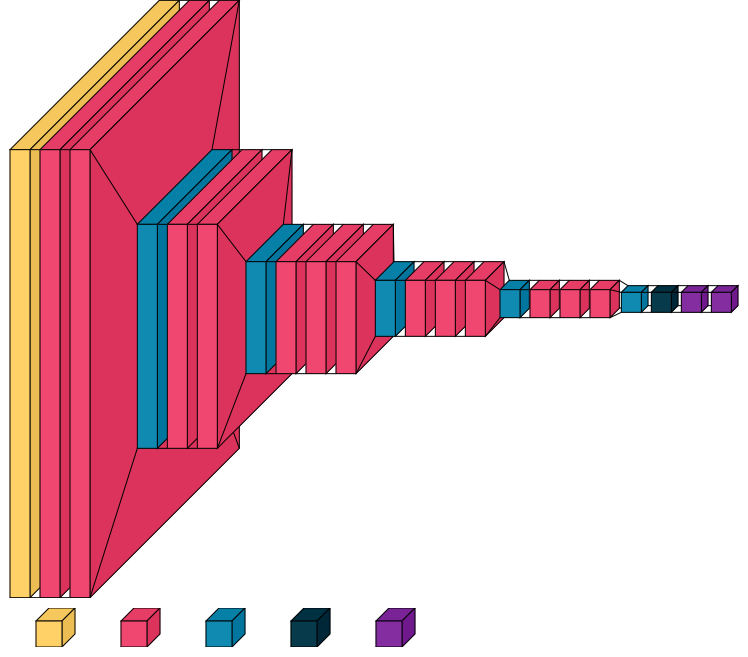

In [7]:

font = ImageFont.truetype("/Library/Fonts/Webdings.ttf", 32)  # using comic sans is strictly prohibited!

visualkeras.layered_view(vgg16_model,legend=True, scale_xy=2, scale_z=0.01, font=font, to_file="image_output/simple_model_arch.png")

# Defining function

In [8]:
class TimeHistory(keras.callbacks.Callback):
    """
    Define a callback to store the runtime per epoch while training a neural network
    """

    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)


def loss_accuracy_plot(hist):
    """
    Create 2 plots to understand the performance of the network during training.
    The left plot includes the validation and training loss.
    The right plot presents the training and validation accuracy

    - Input: training history as a list type, such as the history object from training
    a neural network

    - Output: 1x2 plot
    """
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].plot(
        range(1, len(hist.history["loss"]) + 1),
        hist.history["loss"],
        label="training loss",
    )
    axes[0].plot(
        range(1, len(hist.history["loss"]) + 1),
        hist.history["val_loss"],
        label="validation loss",
    )
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].set_title("Loss evolution")
    axes[0].legend(loc="best")
    axes[0].grid()

    axes[1].plot(
        range(1, len(hist.history["loss"]) + 1),
        hist.history["accuracy"],
        label="training accuracy",
    )
    axes[1].plot(
        range(1, len(hist.history["loss"]) + 1),
        hist.history["val_accuracy"],
        label="validation accuracy",
    )
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")
    axes[1].set_title("Accuracy evolution")
    axes[1].legend(loc="best")
    axes[1].grid()


def loss_accuracy_plot_loaded_hist(hist):
    """
    Create 2 plots to understand the performance of the network during training.
    The left plot includes the validation and training loss.
    The right plot presents the training and validation accuracy

    - Input: training history as a dict type, such laoding the training history
    stored in a json file

    - Output: 1x2 plot
    """

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].plot(
        range(1, len(hist["loss"]) + 1),
        hist["loss"],
        label="training loss",
    )
    axes[0].plot(
        range(1, len(hist["loss"]) + 1),
        hist["val_loss"],
        label="validation loss",
    )
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].set_title("Loss evolution")
    axes[0].legend(loc="best")
    axes[0].grid()

    axes[1].plot(
        range(1, len(hist["loss"]) + 1),
        hist["accuracy"],
        label="training accuracy",
    )
    axes[1].plot(
        range(1, len(hist["loss"]) + 1),
        hist["val_accuracy"],
        label="validation accuracy",
    )
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")
    axes[1].set_title("Accuracy evolution")
    axes[1].legend(loc="best")
    axes[1].grid()

# Traning VGG

In [9]:
t = datetime.datetime.now()
vgg16_time_callback = TimeHistory()
hist_vgg16 = vgg16_model.fit(
     train_data_scaled, validation_data=test_data_scaled, callbacks=[vgg16_time_callback], epochs=20
 )
print("Training time: %s" % (datetime.datetime.now() - t))

# Save the model and its training history
vgg16_model.save("models_data/vgg16.model.keras")
json.dump(hist_vgg16.history, open("models_data/hist_vgg16.json", "w"))
pickle.dump(vgg16_time_callback.times, open("models_data/epoch_time_vgg16.pkl", "wb"))

Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.4492 - loss: 0.6992 - val_accuracy: 0.5260 - val_loss: 0.6859
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.5467 - loss: 0.6881 - val_accuracy: 0.6068 - val_loss: 0.6814
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.5910 - loss: 0.6868 - val_accuracy: 0.6458 - val_loss: 0.6772
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.6140 - loss: 0.6857 - val_accuracy: 0.6849 - val_loss: 0.6730
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.5808 - loss: 0.6841 - val_accuracy: 0.6875 - val_loss: 0.6696
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.6063 - loss: 0.6819 - val_accuracy: 0.6901 - val_loss: 0.6667
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.6119 - loss: 0.6795 - val_accuracy: 0.6901 - val_loss: 0.6639
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.6204 - loss: 0.6773 - val_accuracy: 0.7031 - val_loss:

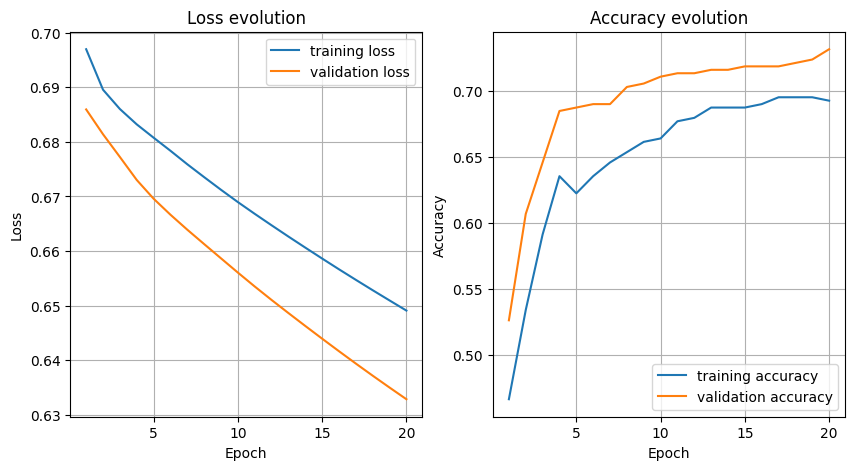

In [11]:
# Load data from VGG16 model
vgg16_model = tf.keras.models.load_model("models_data/vgg16.model.keras")
hist_vgg16 = json.load(open("models_data/hist_vgg16.json", "r"))
epoch_times_vgg16 = pickle.load(open("models_data/epoch_time_vgg16.pkl", "rb"))

# Plot loss and accuracy
if type(hist_vgg16) == dict:
    loss_accuracy_plot_loaded_hist(hist_vgg16)
else:
    loss_accuracy_plot(hist_vgg16)

In [12]:
# Load and preprocess the image
img_path = "./casts/casting_data/casting_data/train/def_front/900.jpeg"
img = keras.utils.load_img(img_path, target_size=(224, 224))  # Resize image to match input shape
img_array = keras.utils.img_to_array(img)  # Convert image to array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension (1, 224, 224, 3)

# Scale the image (same as your training images)
img_array = img_array / 255.0  # Rescale the image

# Make a prediction
predictions = vgg16_model.predict(img_array)

# Print the prediction result
print(f"Predicted class: {predictions[0]}")

if predictions[0] > 0.5:
    print("Predicted class: Non-defective")
else:
    print("Predicted class: Defective")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
Predicted class: [0.4632765]
Predicted class: Defective
